# Constraint Satisfaction Problems Lab

## Introduction
Constraint Satisfaction is a technique for solving problems by expressing limits on the values of each variable in the solution with mathematical constraints.  We've used constraints before -- constraints in the Sudoku project are enforced implicitly by filtering the legal values for each box, and the planning project represents constraints as arcs connecting nodes in the planning graph -- but in this lab exercise we will use a symbolic math library to explicitly construct binary constraints and then use Backtracking to solve the N-queens problem (which is a generalization [8-queens problem](https://en.wikipedia.org/wiki/Eight_queens_puzzle)).  Using symbolic constraints should make it easier to visualize and reason about the constraints (especially for debugging), but comes with a performance penalty.

![8-queens puzzle solution](EightQueens.gif)

Briefly, the 8-queens problem asks you to place 8 queens on a standard 8x8 chessboard such that none of the queens are in "check" (i.e., no two queens occupy the same row, column, or diagonal). The N-queens problem generalizes the puzzle to to any size square board.

## I. Lab Overview
Students should read through the code and the wikipedia page (or other resources) to understand the N-queens problem, then:

0. Complete the warmup exercises in the [Sympy_Intro notebook](Sympy_Intro.ipynb) to become familiar with they sympy library and symbolic representation for constraints
0. Implement the [NQueensCSP class](#II.-Representing-the-N-Queens-Problem) to develop an efficient encoding of the N-queens problem and explicitly generate the constraints bounding the solution
0. Write the [search functions](#III.-Backtracking-Search) for recursive backtracking, and use them to solve the N-queens problem
0. (Optional) Conduct [additional experiments](#IV.-Experiments-%28Optional%29) with CSPs and various modifications to the search order (minimum remaining values, least constraining value, etc.)

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from util import constraint, displayBoard
from sympy import *
from IPython.display import display
init_printing()
%matplotlib inline

## II. Representing the N-Queens Problem
There are many acceptable ways to represent the N-queens problem, but one convenient way is to recognize that one of the constraints (either the row or column constraint) can be enforced implicitly by the encoding.  If we represent a solution as an array with N elements, then each position in the array can represent a column of the board, and the value at each position can represent which row the queen is placed on.

In this encoding, we only need a constraint to make sure that no two queens occupy the same row, and one to make sure that no two queens occupy the same diagonal.

### Define Symbolic Expressions for the Problem Constraints
Before implementing the board class, we need to construct the symbolic constraints that will be used in the CSP.  Declare any symbolic terms required, and then declare two generic constraint generators:
- `diffRow` - generate constraints that return True if the two arguments do not match
- `diffDiag` - generate constraints that return True if two arguments are not on the same diagonal (Hint: you can easily test whether queens in two columns are on the same diagonal by testing if the difference in the number of rows and the number of columns match)

Both generators should produce binary constraints (i.e., each should have two free symbols) once they're bound to specific variables in the CSP.  For example, Eq((a + b), (b + c)) is not a binary constraint, but Eq((a + b), (b + c)).subs(b, 1) _is_ a binary constraint because one of the terms has been bound to a constant, so there are only two free variables remaining. 

In [13]:
# Declare any required symbolic variables
a,b = symbols('a b')
rows = symbols('X:2')
col_diff = Symbol('Y')

# Define diffRow and diffDiag constraints
#raise NotImplementedError("TODO: create the diffRow and diffDiag constraint generators")
diffRow = constraint("diffRow",Ne(a,b))
diffDiag = constraint("diffDiag",And(Ne(rows[0], rows[1] + col_diff),Ne(rows[0], rows[1] - col_diff)))

In [18]:
{x: set() for x in symbols('A:%d' % 8)}

In [15]:
# Test diffRow and diffDiag
_x = symbols("x:3")

# generate a diffRow instance for testing
#raise NotImplementedError("TODO: use your diffRow constraint to generate a diffRow constraint for _x[0] and _x[1]")
diffRow_test = constraint("diffRow",Ne(_x[0],_x[1]))

assert(len(diffRow_test.free_symbols) == 2)
assert(diffRow_test.subs({_x[0]: 0, _x[1]: 1}) == True)
assert(diffRow_test.subs({_x[0]: 0, _x[1]: 0}) == False)
assert(diffRow_test.subs({_x[0]: 0}) != False)  # partial assignment is not false
print("Passed all diffRow tests.")

# generate a diffDiag instance for testing
diffDiag_test = diffDiag.subs({rows[0]: _x[0], rows[1]: _x[2], col_diff: 2})

assert(len(diffDiag_test.free_symbols) == 2)
assert(diffDiag_test.subs({_x[0]: 0, _x[2]: 2}) == False)
assert(diffDiag_test.subs({_x[0]: 0, _x[2]: 0}) == True)
assert(diffDiag_test.subs({_x[0]: 0}) != False)  # partial assignment is not false
print("Passed all diffDiag tests.")

Passed all diffRow tests.
Passed all diffDiag tests.


### The N-Queens CSP Class
Implement the CSP class as described above, with constraints to make sure each queen is on a different row and different diagonal than every other queen, and a variable for each column defining the row that containing a queen in that column.

In [23]:
class NQueensCSP:
    """CSP representation of the N-queens problem
    
    Parameters
    ----------
    N : Integer
        The side length of a square chess board to use for the problem, and
        the number of queens that must be placed on the board
    """
    def __init__(self, N):
        _vars = symbols("a:%d" % N)
        _domain = set(range(N))
        self.size = N
        self.variables = _vars
        self.domains = {v: _domain for v in _vars}
        self._constraints = {x: set() for x in _vars}

        for i in range(N):
            for j in [j for j in range(N) if i < j]:
                xi = _vars[i]
                xj = _vars[j]
                diffRow_constraint = diffRow.subs({rows[0]: xi, rows[1]: xj})
                diffDiag_constraint = diffDiag.subs({rows[0]: xi, rows[1]: xj, col_diff: j-i})
                self._constraints[xi].update({diffRow_constraint, diffDiag_constraint})
                self._constraints[xj].update({diffRow_constraint, diffDiag_constraint})
                
                
    @property
    def constraints(self):
        """Read-only list of constraints -- cannot be used for evaluation """
        constraints = set()
        for _cons in self._constraints.values():
            constraints |= _cons
        return list(constraints)
    
    def is_complete(self, assignment):
        """An assignment is complete if it is consistent, and all constraints
        are satisfied.
        
        Hint: Backtracking search checks consistency of each assignment, so checking
        for completeness can be done very efficiently
        
        Parameters
        ----------
        assignment : dict(sympy.Symbol: Integer)
            An assignment of values to variables that have previously been checked
            for consistency with the CSP constraints
        """
        return len(assignment) == self.size

    def is_consistent(self, var, value, assignment):
        """Check consistency of a proposed variable assignment
                
        self._constraints[x] returns a set of constraints that involve variable `x`.
        An assignment is consistent unless the assignment it causes a constraint to
        return False (partial assignments are always consistent).
        
        Parameters
        ----------
        var : sympy.Symbol
            One of the symbolic variables in the CSP
            
        value : Numeric
            A valid value (i.e., in the domain of) the variable `var` for assignment

        assignment : dict(sympy.Symbol: Integer)
            A dictionary mapping CSP variables to row assignment of each queen
            
        """
        for constraint in self._constraints[var]:
            assignment_constraint = constraint.subs(var, value)
            assignment_constraint = assignment_constraint.subs(assignment)
            if not assignment_constraint:
                return False
        return True

        
    def inference(self, var, value):
        """Perform logical inference based on proposed variable assignment
        
        Returns an empty dictionary by default; function can be overridden to
        check arc-, path-, or k-consistency; returning None signals "failure".
        
        Parameters
        ----------
        var : sympy.Symbol
            One of the symbolic variables in the CSP
        
        value : Integer
            A valid value (i.e., in the domain of) the variable `var` for assignment
            
        Returns
        -------
        dict(sympy.Symbol: Integer) or None
            A partial set of values mapped to variables in the CSP based on inferred
            constraints from previous mappings, or None to indicate failure
        """
        # TODO (Optional): Implement this function based on AIMA discussion
        return {}
    
    def show(self, assignment):
        """Display a chessboard with queens drawn in the locations specified by an
        assignment
        
        Parameters
        ----------
        assignment : dict(sympy.Symbol: Integer)
            A dictionary mapping CSP variables to row assignment of each queen
            
        """
        locations = [(i, assignment[j]) for i, j in enumerate(self.variables)
                     if assignment.get(j, None) is not None]
        displayBoard(locations, self.size)


## III. Backtracking Search
Implement the [backtracking search](https://github.com/aimacode/aima-pseudocode/blob/master/md/Backtracking-Search.md) algorithm (required) and helper functions (optional) from the AIMA text.  

In [26]:
def select(csp, assignment):
    """Choose an unassigned variable in a constraint satisfaction problem """
    # TODO (Optional): Implement a more sophisticated selection routine from AIMA
    for var in csp.variables:
        if var not in assignment:
            return var
    return None

def order_values(var, assignment, csp):
    """Select the order of the values in the domain of a variable for checking during search;
    the default is lexicographically.
    """
    return csp.domains[var]

def backtracking_search(csp):
    """Helper function used to initiate backtracking search """
    return backtrack({}, csp)

def backtrack(assignment, csp):
    """Perform backtracking search for a valid assignment to a CSP
    
    Parameters
    ----------
    assignment : dict(sympy.Symbol: Integer)
        An partial set of values mapped to variables in the CSP
        
    csp : CSP
        A problem encoded as a CSP. Interface should include csp.variables, csp.domains,
        csp.inference(), csp.is_consistent(), and csp.is_complete().
    
    Returns
    -------
    dict(sympy.Symbol: Integer) or None
        A partial set of values mapped to variables in the CSP, or None to indicate failure
    """
    
    if csp.is_complete(assignment):
        return assignment
    
    var = select(csp, assignment)
    for val in order_values(var, assignment, csp):
        if csp.is_consistent(var, val, assignment):
            assignment[var] = val
            inferences = csp.inference(var, val)
            if inferences is not None:
                assignment.update(inferences)
                result = backtrack(assignment, csp)
                if result:
                    return result
            del assignment[var]
            for inferenced_var in inferences.keys():
                del assignment[inferenced_var]
    return None


### Solve the CSP
With backtracking implemented, now you can use it to solve instances of the problem. We've started with the classical 8-queen version, but you can try other sizes as well.  Boards larger than 12x12 may take some time to solve because sympy is slow in the way its being used here, and because the selection and value ordering methods haven't been implemented.  See if you can implement any of the techniques in the AIMA text to speed up the solver!

CSP problems have variables, each variable has a domain, and the problem has a list of constraints.
Showing the variables for the N-Queens CSP:


Showing domain for a0:


And showing the constraints for a0:


Solving N-Queens CSP...


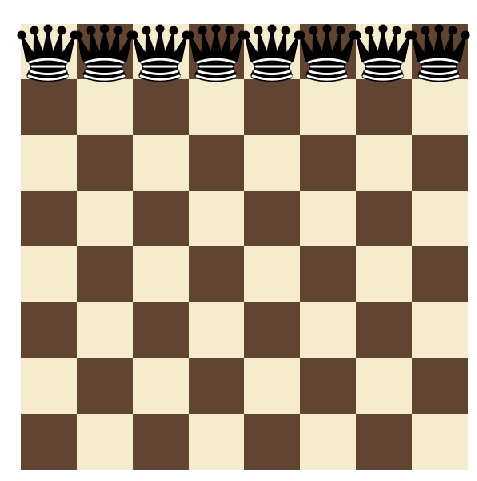

Solution found:
{a0: 0, a1: 0, a2: 0, a3: 0, a4: 0, a5: 0, a6: 0, a7: 0}


In [27]:
num_queens = 8
csp = NQueensCSP(num_queens)
var = csp.variables[0]
print("CSP problems have variables, each variable has a domain, and the problem has a list of constraints.")
print("Showing the variables for the N-Queens CSP:")
display(csp.variables)
print("Showing domain for {}:".format(var))
display(csp.domains[var])
print("And showing the constraints for {}:".format(var))
display(csp._constraints[var])

print("Solving N-Queens CSP...")
assn = backtracking_search(csp)
if assn is not None:
    csp.show(assn)
    print("Solution found:\n{!s}".format(assn))
else:
    print("No solution found.")

## IV. Experiments (Optional)
For each optional experiment, discuss the answers to these questions on the forum: Do you expect this change to be more efficient, less efficient, or the same?  Why or why not?  Is your prediction correct?  What metric did you compare (e.g., time, space, nodes visited, etc.)?

- Implement a _bad_ N-queens solver: generate & test candidate solutions one at a time until a valid solution is found.  For example, represent the board as an array with $N^2$ elements, and let each element be True if there is a queen in that box, and False if it is empty.  Use an $N^2$-bit counter to generate solutions, then write a function to check if each solution is valid.  Notice that this solution doesn't require any of the techniques we've applied to other problems -- there is no DFS or backtracking, nor constraint propagation, or even explicitly defined variables.
- Use more complex constraints -- i.e., generalize the binary constraint RowDiff to an N-ary constraint AllRowsDiff, etc., -- and solve the problem again.
- Rewrite the CSP class to use forward checking to restrict the domain of each variable as new values are assigned.
- The sympy library isn't very fast, so this version of the CSP doesn't work well on boards bigger than about 12x12.  Write a new representation of the problem class that uses constraint functions (like the Sudoku project) to implicitly track constraint satisfaction through the restricted domain of each variable.  How much larger can you solve?
- Create your own CSP!